# Model Selection

The goal of this notebook is to compare algorithms in predicting the changes in the number of residential units under FAIR Plan policy and, as a secondary target, the total exposure acquired by the program.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')
pd.options.display.float_format = '{:.5f}'.format

CLEAN_DATA_DIR = Path('clean_data/')

In [52]:
df = pd.read_csv(CLEAN_DATA_DIR / 'engineered_dataset.csv', index_col=0)
df.sample(3)

,Housing Units,Median Gross Rent ($),Median Owner Cost ($),Median Owner Cost ($) - 2019,% Change - Owner Cost ($),Median Home Value - Census ($),New Policies,Renewed Policies,Nonrenewed Policies (by Owner),Nonrenewed Policies (by Company),...,Growth in Losses to All Disasters 10yr Ratio,Growth in Losses to Fire Disasters 3yr Ratio,Growth in Losses to Fire Disasters 5yr Ratio,Growth in Losses to Fire Disasters 10yr Ratio,Premium to Exposure Ratio,Nonrenewal Rate,Loss Burden per Unit,Loss Burden per Exposure,Premium Adequacy,Renewal Resilience
ZIP Code,,,,,,,,,,,,,,,,,,,,,
93012,13984.00000,2440.00000,794.00000,770.00000,0.03117,657700.00000,4326.00000,34202.00000,3543.00000,616.00000,...,-0.00254,-0.01015,-0.00508,-0.00406,5766.78463,0.10842,421.39407,421.39407,13.68502,0.89158
94555,12057.00000,2773.00000,779.00000,745.00000,0.04564,1078400.00000,3887.00000,31070.00000,3440.00000,351.00000,...,-0.13576,-0.40727,-0.40727,-0.27151,3990.72862,0.10875,170.66406,170.66406,23.38353,0.89125
92557,15222.00000,1730.00000,546.00000,482.00000,0.13278,362200.00000,8301.00000,45037.00000,5609.00000,2272.00000,...,0.41062,0.61593,0.61593,0.41062,3603.95781,0.14893,601.95695,601.95695,5.98707,0.85107


## Train-test split

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

## Evaluation metrics

We will use mean squared error (MSE) as our main evaluation metric, but we will also compute RMSE and MAE. 

For model predicting total exposure, we also will include an additional metric called 'global_difference'. This metric calculates, in USD, the absolute difference between the predicted total exposure and the actual one.

In [55]:
from CrossValidation import * # set of functions to help with model evaluation

## Feature Selections

Based on our EDA, we selected a series of feature sets to train and benchmark our models, which is described below.

In [ ]:
# use the format
# 'feature_set_name': (target, [features]) 
targets = ['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
all_features = df.columns.difference(targets).tolist()

In [ ]:
# most important features according to EDA for % FAIR Plan
main_features = ['Renewal Resilience', 
                'Avg Median Income', 
                'Zillow Mean Home Value ($)',
                'Growth in Losses to All Disasters 5yr Ratio',
                'Premium to Exposure Ratio',
                '% Change - Earned Premiums']

# most important features for Total Exposure
exposure_features = ['Earned Premium ($)',
                    '% Nonrenewed Policies (by Company)',
                    '% Change - Nonrenewed Policies (by Company)',
                    'Avg % White-only Pop',
                    '% Change - Zillow Home Value',
                    '% Change - Earned Premiums',
                    'Claims (Fire and Smoke)',
                    'Avg Median Income',
                    '% Change - Claims (Fire and Smoke)',
                    'Losses (Fire and Smoke) ($)',
                    'Median Owner Cost ($)']

# Features that capture changes over time and/or past events
dynamic_features = ['% Change - Claims (Fire and Smoke)',
                    '% Change - Earned Premiums',
                    '% Change - Losses (Fire and Smoke)',
                    '% Change - Zillow Home Value',
                    '% Change Median Income',
                    'All Disasters 5y']

# Best predictors from main model
best_predictors = ['Renewal Resilience', '% Change - Earned Premiums']

# Data not provided by insurance companies
non_insurance = ['% Change - Zillow Home Value',
                'Housing Units',
                'Avg Median Income',
                '% Change - Owner Cost ($)',
                'Median Gross Rent ($)',
                'All Disasters 10y']

feature_sets = {
    'main_%_fair': (targets[1], main_features),    
    'dynamic_%_fair': (targets[1], dynamic_features),
    'best_%_fair': (targets[1], best_predictors),
    'non_ins_%_fair': (targets[1], non_insurance),
    'exposure_main': (targets[2], main_features),    
    'exposure_features': (targets[2], exposure_features),
}

## Model Specification

In [68]:
# baseline model with the mean
def baseline_model(y_train, y_test):
    mu_y = y_train.mean()
    preds = [mu_y] * len(y_test)
    return calculate_metrics(y_test, preds)

In [69]:
# linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [70]:
# knn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=4))
])

# function to find the best K for a given training set
def best_k(y_train, y_test, X_train, X_test, k_upper=20, plot=True):
    rmses = []
    for k in range(1, k_upper):
        knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # fitting and prediction
        knn_pipe.fit(X_train, y_train)
        preds = knn_pipe.predict(X_test)

        # calculating and saving mse
        rmses.append((k, mse(y_test, preds)))

    # plot graph        
    if plot:
        plt.figure(figsize=(6,4))

        plt.plot(np.array(rmses)[:, 0], np.array(rmses)[:, 1])

        plt.ylabel('MSE')
        plt.xlabel('k')

        plt.show()

    best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]
    return best_k


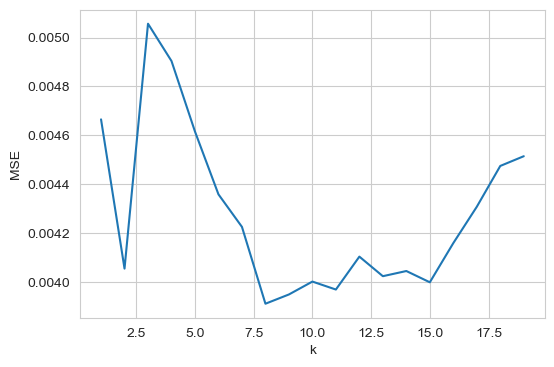

C:\Users\lbarleta\AppData\Local\Temp\ipykernel_18936\3612865308.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]


8

In [71]:
# for feature set 'main_%_fair'
feature_set = feature_sets['main_%_fair']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

best_k(y_train, y_test, X_train, X_test)

In [72]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

grad_bost = GradientBoostingRegressor(
    learning_rate=.1,
    n_estimators=200,
    max_depth=1
)

In [73]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(
    learning_rate=.1,
    n_estimators=200,
    max_depth=1
)

## Cross-validation

In [74]:
from sklearn.model_selection import KFold

kfold = KFold(5)

models = [('Baseline (mean)', None),
          ('Linear Regression', lr), 
          ('kNN - 4', knn), 
          ('Gradient Boosting', grad_bost), 
          ('XGBoost', xgboost)]

In [79]:
def run_cross_val(target, features, set=None,):
    results = []

    for i, (train_index, test_index) in enumerate(kfold.split(df_train)):
        df_tt = df_train.iloc[train_index]
        df_ho = df_train.iloc[test_index]

        for j, model in enumerate(models):
            if model[0] == 'Baseline (mean)':
                eval = baseline_model(df_tt[target], df_ho[target])
            else:
                model[1].fit(df_tt[features], df_tt[target])
                preds = model[1].predict(df_ho[features])
                eval = calculate_metrics(df_ho[target], preds)

            results.append([set, target, model[0]] + eval)

    return results

In [80]:
# running cross-validation for all feature sets
vals = []

for feature_set, data in feature_sets.items():
    target = data[0]
    features = data[1]

    vals += run_cross_val(target, features, feature_set)

In [150]:
eval_table = create_eval_table(vals)

# # making it into millions of dollars\n",?

cols = ['Feature Set', 'Target Variable' ,'Model', 'MSE', 'RMSE', 'MAE', 'Global Diff', 'Total Val']
res = pd.DataFrame(vals, columns=cols)

eval_table.iloc[:, :-2]

MSE  \
Feature Set       Target Variable    Model                                        
best_%_fair       % FAIR Plan Units  Baseline (mean)                    0.00928   
                                     Gradient Boosting                  0.00382   
                                     Linear Regression                  0.00447   
                                     XGBoost                            0.00415   
                                     kNN - 4                            0.00440   
dynamic_%_fair    % FAIR Plan Units  Baseline (mean)                    0.00928   
                                     Gradient Boosting                  0.00506   
                                     Linear Regression                  0.00536   
                                     XGBoost                            0.00515   
                                     kNN - 4                            0.00559   
exposure_features Total Exposure ($) Baseline (mean)   128703483624974432.00000   
                                     Gradient Boosting  86322929451004384.00000   
                                     Linear Regression  83169085337263968.00000   
                                     XGBoost            67890078247985320.00000   
                                     kNN - 4            82851500134986560.00000   
exposure_main     Total Exposure ($) Baseline (mean)   128703483624974432.00000   
                                     Gradient Boosting 113456897037352304.00000   
                                     Linear Regression  98658498253316624.00000   
                                     XGBoost           110286129525507840.00000   
                                     kNN - 4           103015093425734320.00000   
main_%_fair       % FAIR Plan Units  Baseline (mean)                    0.00928   
                                     Gradient Boosting                  0.00364   
                                     Linear Regression                  0.00420   
                                     XGBoost                            0.00382   
                                     kNN - 4                            0.00350   
non_ins_%_fair    % FAIR Plan Units  Baseline (mean)                    0.00928   
                                     Gradient Boosting                  0.00796   
                                     Linear Regression                  0.00823   
                                     XGBoost                            0.00795   
                                     kNN - 4                            0.00786   

                                                                  RMSE  \
Feature Set       Target Variable    Model                               
best_%_fair       % FAIR Plan Units  Baseline (mean)           0.09559   
                                     Gradient Boosting         0.06136   
                                     Linear Regression         0.06671   
                                     XGBoost                   0.06406   
                                     kNN - 4                   0.06617   
dynamic_%_fair    % FAIR Plan Units  Baseline (mean)           0.09559   
                                     Gradient Boosting         0.07088   
                                     Linear Regression         0.07295   
                                     XGBoost                   0.07140   
                                     kNN - 4                   0.07435   
exposure_features Total Exposure ($) Baseline (mean)   350161152.14192   
                                     Gradient Boosting 274818021.89404   
                                     Linear Regression 280441437.41385   
                                     XGBoost           249637130.00647   
                                     kNN - 4           275215960.88200   
exposure_main     Total Exposure ($) Baseline (mean)   350161152.14192   
                                     Gradient Boosting 330441923.93984   
             

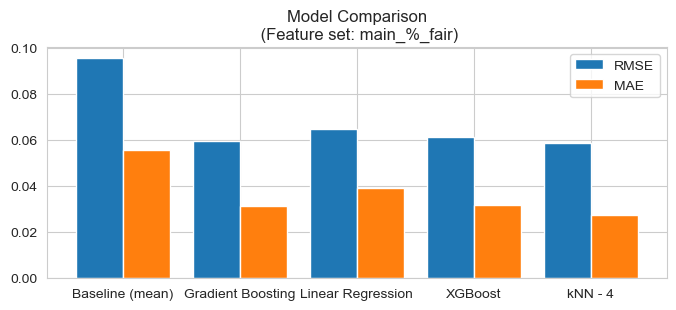

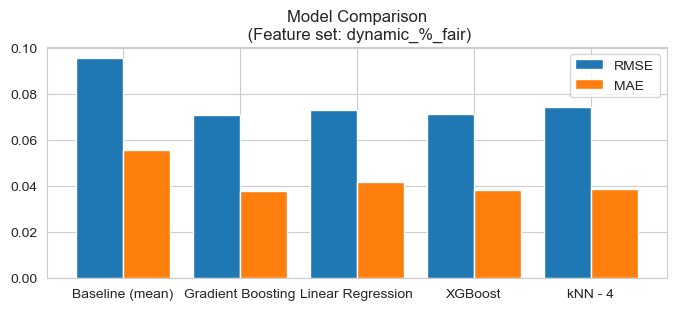

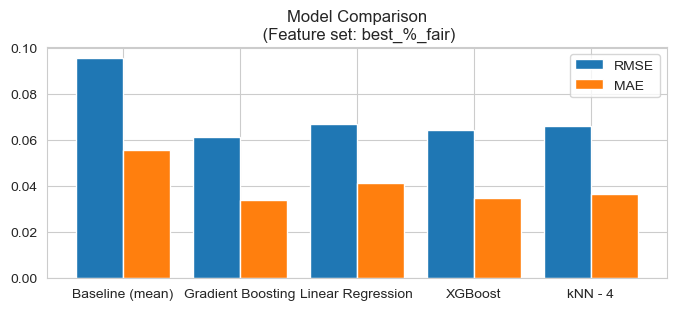

In [87]:
plot_metrics(eval_table, 'main_%_fair')
plot_metrics(eval_table, 'dynamic_%_fair')
plot_metrics(eval_table, 'best_%_fair')

## Comparing to Classification Algorithms (and their probability) 

An issue we encountered with our model is to that out target variable is a percentage. Most regressors, however, are not bounded at (0,1) and can potentially predict data outside this range. A possible solution is to adapt classification algorithms that generate probabilities and use them as our predictors. Based on Steven Gubkin's implementation of an AggregatedClassifierWrapper, we compare our best regressors to a Logistic Regression classifier.

In [ ]:
from AggregatedClassifierWrapper import AggregatedClassifierWrapper
from sklearn.linear_model import LogisticRegression

features = feature_sets['main_%_fair'][1] 
target = '% FAIR Plan Units'             # already a proportion (0 to 1)
population_col = 'Total Res Units'       # ZIP code population count

X_train, X_test = df_train[features], df_test[features]
pop_train, pop_test = df_train[population_col], df_test[population_col]
pct_train, pct_test = df_train[target], df_test[target]

In [ ]:
# scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# fitting model
clf = AggregatedClassifierWrapper(LogisticRegression(solver='lbfgs', max_iter=1000))
clf.fit(X_train_scaled, pop_train, pct_train)

# predicting probabilities of class 1 (i.e., FAIR Plan)
probs = clf.predict_proba(X_test_scaled)[:, 1]

# evaluation
mets = calculate_metrics(pct_test.values, probs)

print(f"MSE for Log Reg: {mets[0]}")
print(f"RMSE for Log Reg: {mets[1]}")
print(f"MAE for Log Reg: {mets[2]}")

MSE for Log Reg: 0.006485440605193002
RMSE for Log Reg: 0.08053223333046838
MAE for Log Reg: 0.037626531645157155


# Final Validation

Here we train and evalute the two models we'll focus our conclusions. 

## Predicting % of FAIR Plan Coverage

The model that performed best was the feature set "main_%_fair" using gradient boosting and XGBoost. Now let's retrain the model in the entire training data and perform final validation on the test set.

In [102]:
# the winner 
feature_set =  feature_sets['main_%_fair']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

In [114]:
grad_bost.fit(X_train, y_train)
preds = grad_bost.predict(X_test)

xgboost.fit(X_train, y_train)
preds2 = xgboost.predict(X_test)

lr.fit(X_train, y_train)
preds3 = lr.predict(X_test)

res = pd.DataFrame({
        'baseline_model': baseline_model(y_train, y_test),
        'grad_bost': calculate_metrics(y_test, preds),
        'xgboost': calculate_metrics(y_test, preds2),
        'lr': calculate_metrics(y_test, preds3),

    }).T.iloc[:, :-2].rename({0: 'MSE', 1: 'RMSE', 2: 'MAE'}, axis=1)

res

,MSE,RMSE,MAE
baseline_model,217172289561629696.00000,466017477.74266,205342408.76411
grad_bost,115893291890241520.00000,340431038.37670,133690584.26995
xgboost,94888422424221744.00000,308039644.24116,128117989.00939
lr,103983734452684432.00000,322465090.28527,150946806.30285


XGBoost is generalizing better and we'll use it for our final model!

In [108]:
# grad boosting
pd.DataFrame({
    'Features': xgboost.feature_names_in_,
    'Importance': xgboost.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Features,Importance
5,% Change - Earned Premiums,0.45860
0,Renewal Resilience,0.43708
4,Premium to Exposure Ratio,0.05018
1,Avg Median Income,0.02686
2,Zillow Mean Home Value ($),0.01616
3,Growth in Losses to All Disasters 5yr Ratio,0.01113


In [110]:
# generating and saving
preds = xgboost.predict(df[feature_set[1]])

pd.DataFrame({
    'ZIP Code': df.index,
    'True Value': df[feature_set[0]],
    'Predictions (GB)': preds
}).to_csv(CLEAN_DATA_DIR / 'best_predictions.csv')

## Predicting Total Exposure acquired through the FAIR Plan program

The best model for predicting exposure had different features, and here we perform our final evaluation. In addition to commom 

In [112]:
# the winner 
feature_set =  feature_sets['exposure_features']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

In [ ]:
res = pd.DataFrame({
        'baseline_model': baseline_model(y_train, y_test),
        'grad_bost': calculate_metrics(y_test, preds),
        'xgboost': calculate_metrics(y_test, preds2),
        'lr': calculate_metrics(y_test, preds3),

    }).T.rename({0: 'MSE', 1: 'RMSE', 2: 'MAE', 3: 'AE (mi)'}, axis=1)

# Here we calculate how off, in millions of dollars, our prediction was
res['% Diff - Total Exposure (mi)'] = res['AE (mi)'] / res[4]

res[['RMSE', 'MAE', 'AE (mi)', '% Diff - Total Exposure (mi)']]

,RMSE,MAE,AE (mi),% Diff - Total Exposure (mi)
baseline_model,466017477.74266,205342408.76411,11885.45000,0.28040
grad_bost,340431038.37670,133690584.26995,120.93000,0.00285
xgboost,308039644.24116,128117989.00939,430.17001,0.01015
lr,322465090.28527,150946806.30285,2479.30000,0.05849


The total value for exposure, as calculate by the gradient boosting and XGBoost models, were very close to the actual value. Here we'lluse cross-validation once again to examine how robust this predictions are.

In [231]:
kfold = KFold(10, shuffle=True, random_state=213)

results = []

for i, (train_index, test_index) in enumerate(kfold.split(df_train)):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]

    grad_bost.fit(df_tt[features], df_tt[target])
    preds = grad_bost.predict(df_ho[features])
    
    # calculating total exposure
    total_exposure = sum(df_ho[target])
    predicted_exposure = sum(preds)

    # baseline
    mu_y = sum(df_tt[target]) / len(df_tt)
    baseline_exposure = mu_y * len(df_ho)

    results.append([total_exposure, predicted_exposure, abs(total_exposure-predicted_exposure), baseline_exposure, abs(total_exposure-baseline_exposure)])

res = pd.DataFrame(results, columns=['Total Exp', 'Pred Exp', 'Diff', 'Base Exp', 'Diff Base']) / (1000 * 1000)

res['Pct Pred'] = res['Diff'] / res['Total Exp']
res['Pct Base'] = res['Diff Base'] / res['Total Exp']

res

,Total Exp,Pred Exp,Diff,Base Exp,Diff Base,Pct Pred,Pct Base
0,12858.48777,12689.15162,169.33615,12098.31691,760.17086,0.01317,0.05912
1,14101.23916,11409.15558,2692.08359,11960.06825,2141.17091,0.19091,0.15184
2,9173.79533,9313.31669,139.52136,12508.21691,3334.42158,0.01521,0.36347
3,10790.55284,10306.78485,483.76799,12328.36230,1537.80947,0.04483,0.14251
4,9882.72402,9564.87051,317.85351,12429.35283,2546.62881,0.03216,0.25768
5,14530.30653,10125.94750,4404.35903,11912.33707,2617.96946,0.30312,0.18017
6,16842.00847,15414.58264,1427.42583,11655.17406,5186.83441,0.08475,0.30797
7,11400.47898,12558.51032,1158.03134,12260.51167,860.03269,0.10158,0.07544
8,12566.26340,9459.01507,3107.24833,12130.82512,435.43828,0.24727,0.03465
9,9467.39404,11285.14804,1817.75400,12326.66523,2859.27119,0.19200,0.30201


In [233]:
res.mean(axis=0)

Total Exp   12161.32505
Pred Exp    11212.64828
Diff         1571.73811
Base Exp    12160.98304
Diff Base    2227.97477
Pct Pred        0.12250
Pct Base        0.18749
dtype: float64

The results aren't as good as previous, but our model also performed significantly better than the baseline model in predicting the total exposure that the FAIR Plan program would generate. In the graph below, we can see how each of the test splits behaved.

Text(0.5, 1.0, 'Total Exposure (in millions of US$) in each KFold split')

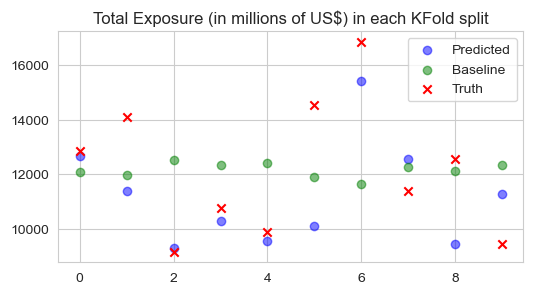

In [ ]:
plt.figure(figsize=(6, 3))

plt.scatter(res.index, res['Pred Exp'], marker='o', color='blue', label='Predicted', alpha=.5)
plt.scatter(res.index, res['Base Exp'], marker='o', color='green', label='Baseline', alpha=.5)
plt.scatter(res.index, res['Total Exp'], marker='x', color='red', label='Truth')

plt.legend()

plt.title('Total Exposure (in millions of US$) in each KFold split')

In [237]:
# sevaing predictions
preds = grad_bost.predict(df[feature_set[1]])

pd.DataFrame({
    'True Value': df[feature_set[0]],
    'Predictions (GB)': preds
}).to_csv(CLEAN_DATA_DIR / 'exposure_predictions.csv')